In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [29]:
# Read file
data = pd.read_csv("./consumption_temp.csv")
# Convert datatypes
data["time"] = pd.to_datetime(data["time"])
data["consumption"] = pd.to_numeric(data["consumption"])
data["temperature"] = pd.to_numeric(data["temperature"])
data_cities = {location: data[data["location"] == location] for location in data["location"].unique()}
print(data.columns)


Index(['time', 'location', 'consumption', 'temperature'], dtype='object')


0        21
5        22
10       23
15        0
20        1
         ..
49464    17
49470    18
49476    19
49482    20
49488    21
Name: hour, Length: 8641, dtype: int64


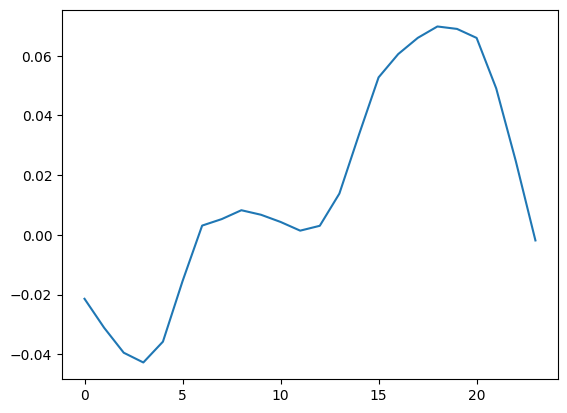

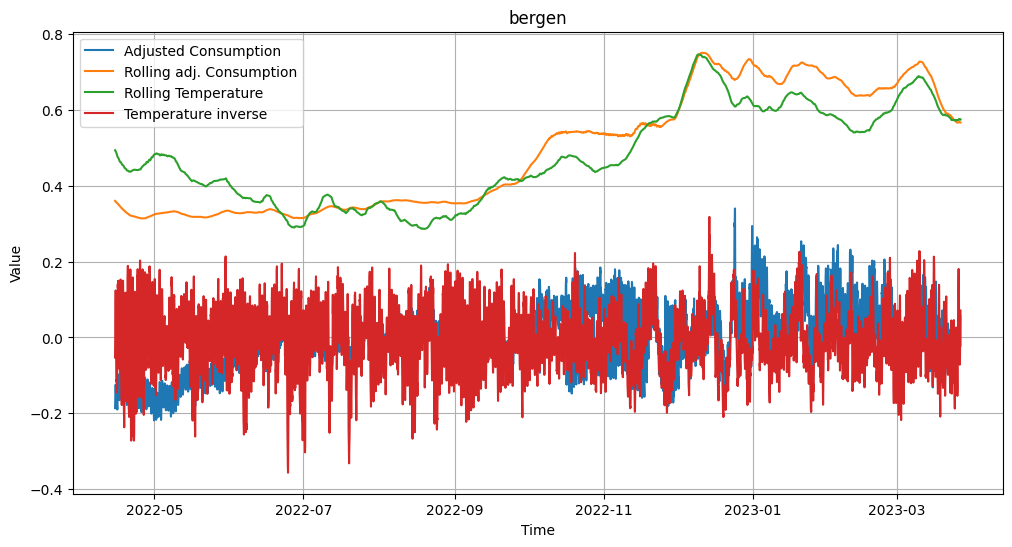

2022-04-07 21:00:00
2023-04-02 21:00:00
1        21
6        22
11       23
16        0
21        1
         ..
49466    17
49472    18
49478    19
49484    20
49490    21
Name: hour, Length: 8641, dtype: int64


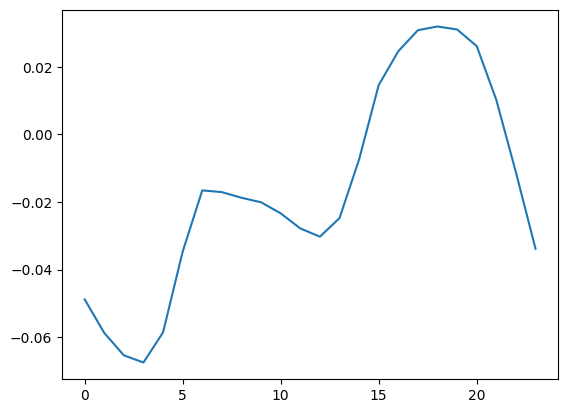

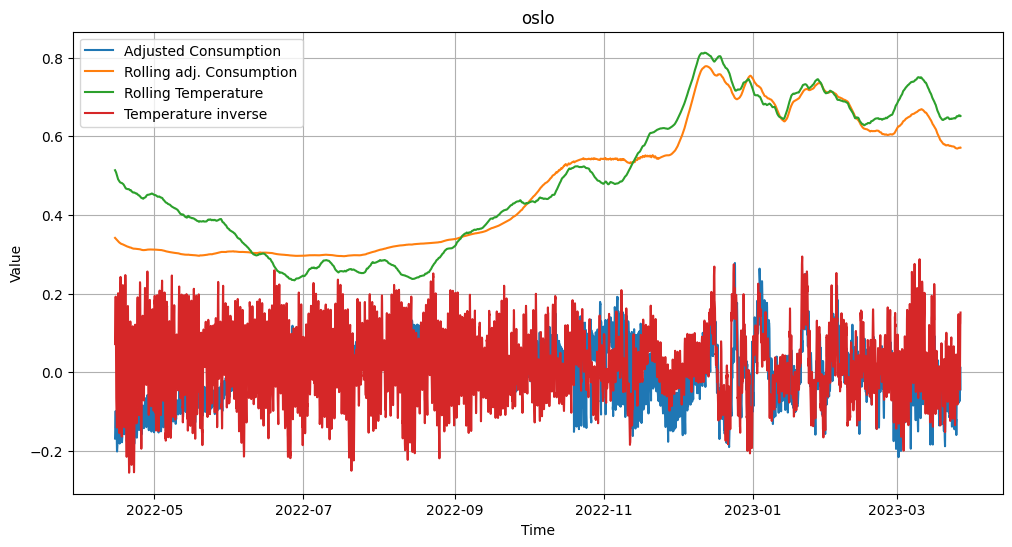

2022-04-07 21:00:00
2023-04-02 21:00:00
2        21
7        22
12       23
17        0
22        1
         ..
49467    17
49473    18
49479    19
49485    20
49491    21
Name: hour, Length: 8641, dtype: int64


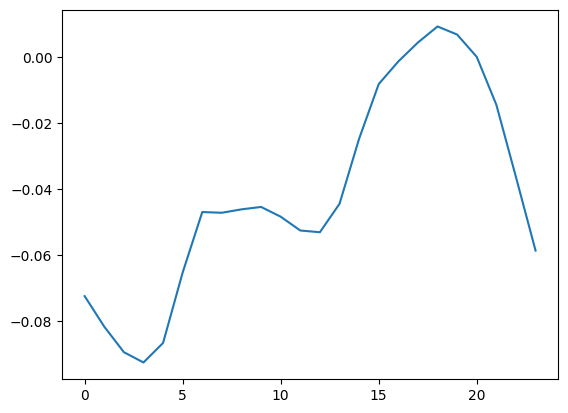

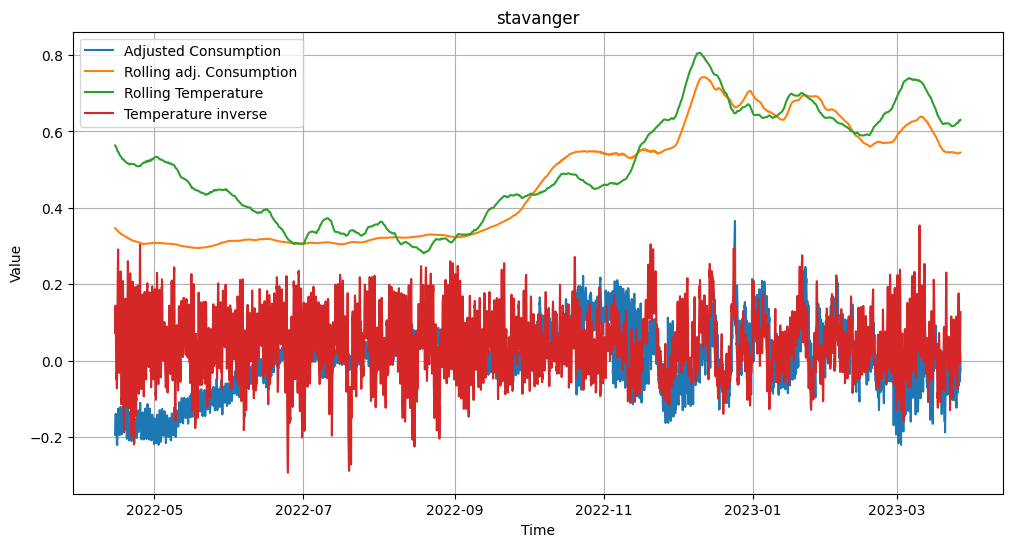

2022-04-07 21:00:00
2023-04-02 21:00:00
3        21
8        22
13       23
18        0
23        1
         ..
49468    17
49474    18
49480    19
49486    20
49492    21
Name: hour, Length: 8641, dtype: int64


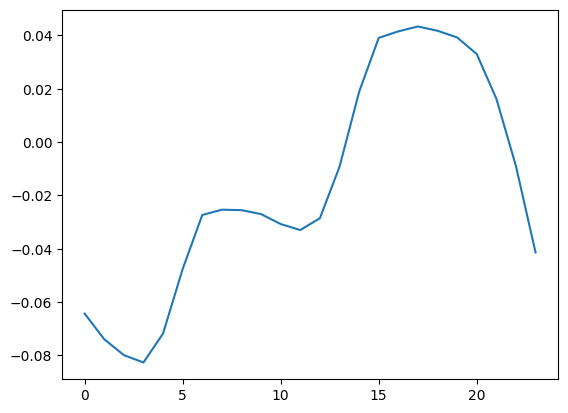

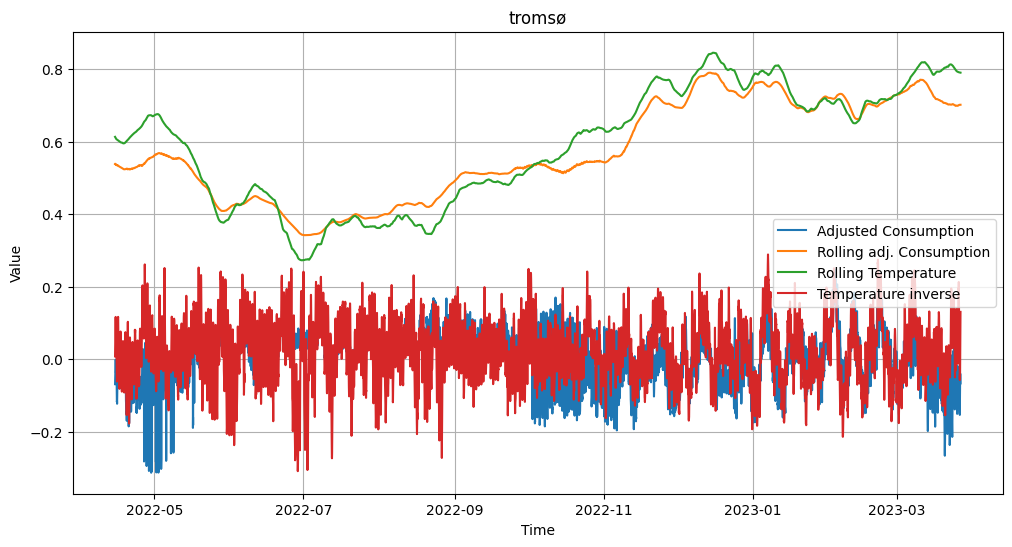

2022-04-07 21:00:00
2023-04-02 21:00:00
4        21
9        22
14       23
19        0
24        1
         ..
49469    17
49475    18
49481    19
49487    20
49493    21
Name: hour, Length: 8641, dtype: int64


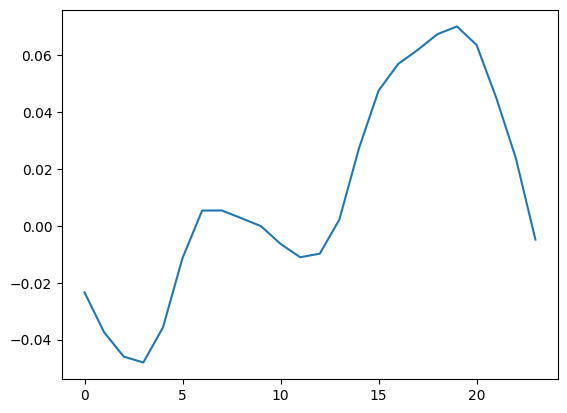

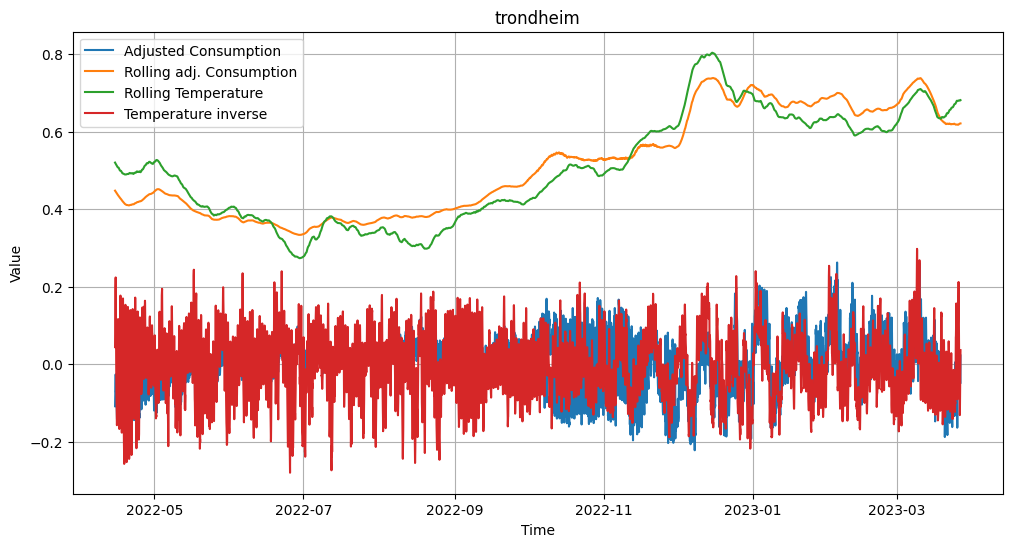

2022-04-07 21:00:00
2023-04-02 21:00:00
11761    21
11767    22
11773    23
11779     0
11785     1
         ..
49465    17
49471    18
49477    19
49483    20
49489    21
Name: hour, Length: 6289, dtype: int64


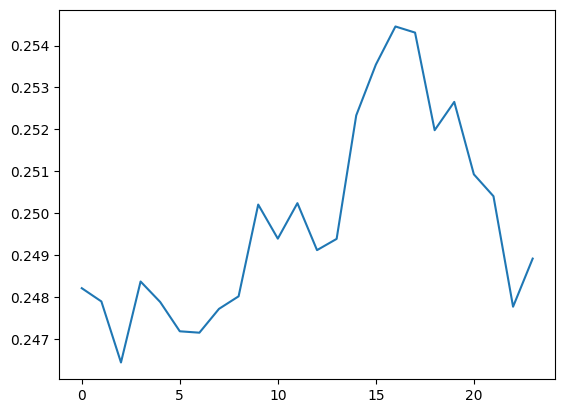

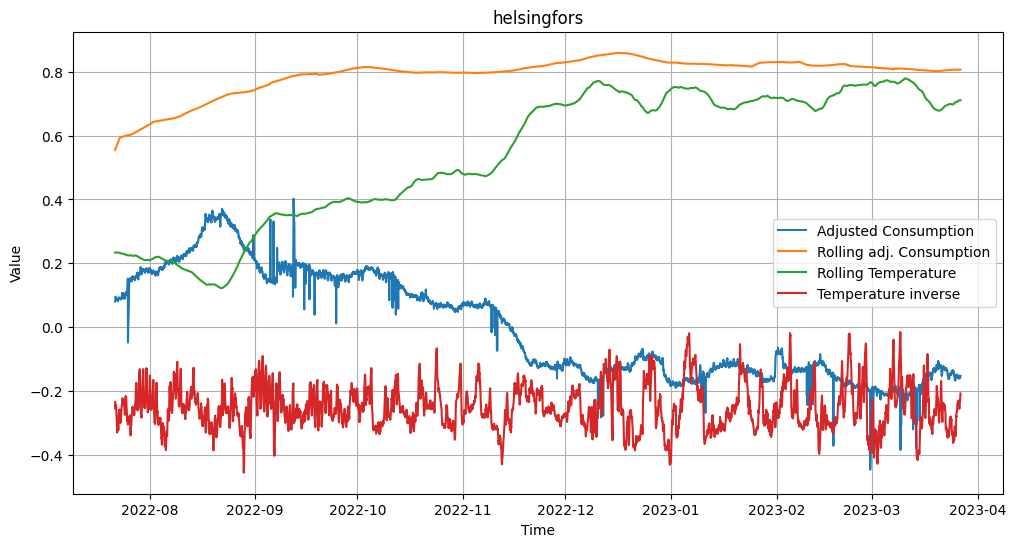

2022-07-14 21:00:00
2023-04-02 21:00:00


In [44]:
normalize_features = True

# Plot
for city, city_data in data_cities.items():

    # Normalize the "consumption" and "temperature" columns using Min-Max scaling
    min_consumption = city_data['consumption'].min()
    max_consumption = city_data['consumption'].max()
    min_temperature = city_data['temperature'].min()
    max_temperature = city_data['temperature'].max()
    norm_city_data = city_data.copy()
    if normalize_features:
        norm_city_data['consumption'] = (city_data['consumption'] - min_consumption) / (max_consumption - min_consumption)
        norm_city_data['temperature'] = 1 - ((city_data['temperature'] - min_temperature) / (max_temperature - min_temperature))

    #1. Up-adjusting summer consumption data
    norm_city_data['adj_consumption'] = norm_city_data['consumption']
    mask = norm_city_data['consumption'] < 0.4
    norm_city_data.loc[mask, 'adj_consumption'] += (mask)/4

    #2. Rolling averages for temperature and adj_consumption
    norm_city_data['rolling_adj_consumption'] = norm_city_data['adj_consumption'].rolling(window=24*7*2, center=True).mean()
    norm_city_data['rolling_temperature'] = norm_city_data['temperature'].rolling(window=24*7*2, center=True).mean()

    #3. Adjust both temperature and consumption based on moving average of adj_consumption
    norm_city_data['adj_consumption'] -= norm_city_data['rolling_temperature']
    norm_city_data['adj_temperature'] = norm_city_data['temperature'] - norm_city_data['rolling_temperature']

    #4. Adjust for typical daily movements
    hourly_data = norm_city_data['adj_consumption'].groupby(norm_city_data['time'].dt.hour).mean()
    plt.plot(hourly_data)
    norm_city_data['hour'] = norm_city_data['time'].dt.hour
    print(norm_city_data['hour'])
    norm_city_data['adj_consumption'] -= norm_city_data['hour'].map(hourly_data)
    norm_city_data['adj_temperature'] -= norm_city_data['hour'].map(hourly_data)
    

    # Plot
    plt.figure(figsize=(12, 6))  # Set the figure size (adjust as needed)

    plt.plot(norm_city_data['time'], norm_city_data['adj_consumption'], label='Adjusted Consumption', linestyle='-')
    plt.plot(norm_city_data['time'], norm_city_data['rolling_adj_consumption'], label='Rolling adj. Consumption', linestyle='-')
    plt.plot(norm_city_data['time'], norm_city_data['rolling_temperature'], label='Rolling Temperature', linestyle='-')
    plt.plot(norm_city_data['time'], norm_city_data['adj_temperature'], label='Temperature inverse', linestyle='-')

    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(city)
    plt.legend()
    plt.grid(True)

    plt.show()

    print(norm_city_data['time'].min())
    print(norm_city_data['time'].max())
    

In [45]:
# Try calculating correlation for our different features

print(norm_city_data.corr())

                         consumption  temperature  adj_consumption  \
consumption                 1.000000     0.567863    -4.765444e-01   
temperature                 0.567863     1.000000    -9.208248e-01   
adj_consumption            -0.476544    -0.920825     1.000000e+00   
rolling_adj_consumption     0.901223     0.762837    -6.489329e-01   
rolling_temperature         0.661430     0.952616    -9.694262e-01   
adj_temperature             0.038171     0.329126    -1.702787e-02   
hour                        0.016677    -0.032563    -2.267075e-16   

                         rolling_adj_consumption  rolling_temperature  \
consumption                             0.901223             0.661430   
temperature                             0.762837             0.952616   
adj_consumption                        -0.648933            -0.969426   
rolling_adj_consumption                 1.000000             0.803413   
rolling_temperature                     0.803413             1.000000   
a

C:\Users\Henrik\AppData\Local\Temp\ipykernel_12232\342642233.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(norm_city_data.corr())
